# EEA Phenology openEO demo
Getting started with openEO

This demo uses the openEO platform openEO backend. 

To run the code, the open source openEO Python client needs to be installed. Basic installation instruction can be found here:

https://docs.openeo.cloud/getting-started/python/


In [12]:
%matplotlib  inline

In [ ]:
!pip install -U --user openeo netcdf4

After successfull installation, we should be able to import openEO, and print the client version to ensure that we are up to date.
The original version was written against 0.13.0

In [3]:
import openeo
openeo.__version__

'0.13.0'

In [4]:
connection = openeo.connect("openeo-dev.creo.vito.be").authenticate_oidc()

To authenticate: visit https://aai.egi.eu/auth/realms/egi/device and enter the user code 'IMYM-TGWF'.
Authorized successfully.
Authenticated using device code flow.


In [5]:
spatial_extent = {'west': 4.45, 'east': 4.70, 'south': 51.16, 'north': 51.22, 'crs': 'epsg:4326'}

## Downloading a raster dataset
This first basic example shows very basic data access for an arbitrary spatiotemporal extent.

* The openEO 'download' call triggers a synchronous request, which is possible for smaller extents that complete in less than 15 minutes.
* netCDF is used as output format because it retains all metadata nicely, and is easy to load with XArray.

In [27]:
%%time
connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2020-03-15","2020-04-15"],spatial_extent=spatial_extent).download("eea_veg.nc")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [28]:
import xarray as xr
ds = xr.open_dataset("eea_veg.nc")
ds

<xarray.Dataset>
Dimensions:  (t: 3, x: 1762, y: 706)
Coordinates:
  * t        (t) datetime64[ns] 2020-03-21 2020-04-01 2020-04-11
  * x        (x) float64 6.013e+05 6.013e+05 6.013e+05 ... 6.189e+05 6.189e+05
  * y        (y) float64 5.676e+06 5.676e+06 5.676e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs      |S1 ...
    PPI      (t, y, x) float32 ...
    QFLAG    (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

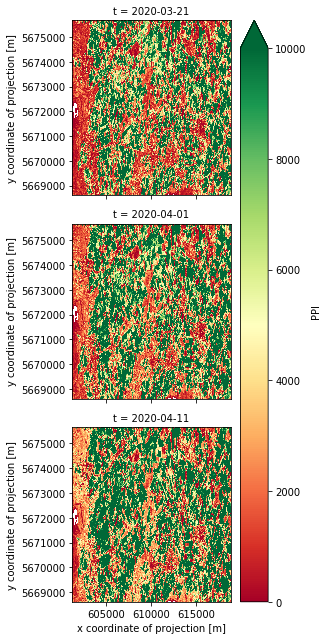

In [13]:
ds.PPI.plot(vmin=0, vmax=10000.0, cmap="RdYlGn", col="t", col_wrap=1)

## Point query
This example retrieves the PPI trajectory over time, using a point query.

We again use netCDF for download which simplifies manipulating and plotting the result as a proper timeseries.

More spatial aggregation examples:
https://open-eo.github.io/openeo-python-client/basics.html#aggregated-evi-timeseries


In [14]:
from shapely.geometry import Point

In [29]:
%%time
cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2018-01-15","2021-12-15"],bands=["PPI"])
cube.aggregate_spatial(Point(5.1032731,51.2644580),reducer="mean").download("eea_veg_ts.nc")

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 16.6 s


In [30]:
ppi_timeseries = xr.open_dataset("eea_veg_ts.nc")
ppi_timeseries

<xarray.Dataset>
Dimensions:        (feature: 1, t: 33)
Coordinates:
  * t              (t) datetime64[ns] 2020-01-21 2020-02-01 ... 2020-12-11
    lat            (feature) float64 ...
    lon            (feature) float64 ...
    feature_names  (feature) object ...
Dimensions without coordinates: feature
Data variables:
    PPI            (feature, t) float64 ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.

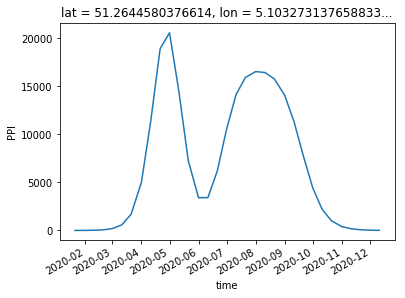

In [31]:
ppi_timeseries.PPI.plot()

## Spatial aggregation over a polygon

This example uses a polygon, which can correspond to an agricultural parcel. 
This time, we retrieve more than one statistic with the same call.

https://open-eo.github.io/openeo-python-client/basics.html#computing-multiple-statistics

In [32]:
import json
parcel = json.loads("""
{
    "type": "FeatureCollection",
    "features": [
        {
            "id": "0",
            "type": "Feature",
            "properties": {
                "id": 0
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            5.103273137658833,
                            51.2644580376614
                        ],
                        [
                            5.105770274251699,
                            51.26289548617123
                        ],
                        [
                            5.104640319943427,
                            51.262395458475154
                        ],
                        [
                            5.102249311655759,
                            51.26381739797543
                        ],
                        [
                            5.103273137658833,
                            51.2644580376614
                        ]
                    ]
                ]
            }
        }
    ]
}
""")

In [33]:
%%time
from openeo.processes import array_create, quantiles, mean, sd
cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2018-01-15","2020-12-15"],bands=["PPI"])

cube.aggregate_spatial(parcel,reducer=lambda pixels: array_create([quantiles(pixels,q=4), mean(pixels),sd(pixels)])).download("eea_veg_ts_full.csv")

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 19.6 s


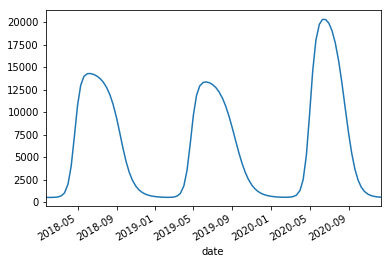

In [35]:
import pandas as pd
df = pd.read_csv("eea_veg_ts_full.csv",index_col=["date","feature_index"],parse_dates=['date']).sort_index()

df.xs(0, level='feature_index', drop_level=True)["avg(band_0)"].plot()

In [36]:
df

,,"percentile_approx(band_0, 0.25, 100000)","percentile_approx(band_0, 0.5, 100000)","percentile_approx(band_0, 0.75, 100000)",avg(band_0),stddev_samp(band_0)
date,feature_index,,,,,
2018-01-21 00:00:00+00:00,0,310,501,693,514.311688,297.690542
2018-02-01 00:00:00+00:00,0,298,499,688,507.926407,297.494039
2018-02-11 00:00:00+00:00,0,301,492,687,511.606061,306.101256
2018-02-21 00:00:00+00:00,0,308,498,701,530.294372,338.777110
2018-03-01 00:00:00+00:00,0,325,518,732,568.385281,399.892446
2018-03-11 00:00:00+00:00,0,411,606,837,688.363636,541.275906
2018-03-21 00:00:00+00:00,0,637,880,1233,1015.904762,768.442139
2018-04-01 00:00:00+00:00,0,1362,1774,2402,1994.233766,1135.328486
2018-04-11 00:00:00+00:00,0,3063,3744,4781,4015.476190,1531.703867


## Masking by start of season

This is a more complex example that shows more advanced openEO capabilities:

* Turning a raster of SOSD values into a binary mask using logical operators
* Applying a mask to the PPI trajectory

In [77]:

sosd = connection.load_collection("VEGETATION_PHENOLOGY_AND_PRODUCTIVITY_PARAMETERS_SEASON_1",spatial_extent=spatial_extent,temporal_extent=["2019-01-01","2019-01-02"], bands=["SOSD"])


In [90]:
%%time
mask = ~((sosd.band("SOSD") >18800)  and  (sosd.band("SOSD") <19000))

cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2020-03-15","2020-04-15"],spatial_extent=spatial_extent, bands=["PPI"])
masked_cube = cube.mask(mask.max_time().resample_cube_spatial(cube))
masked_cube.download("eea_ppi_masked.nc")

CPU times: user 16 ms, sys: 12 ms, total: 28 ms
Wall time: 11 s


In [ ]:
import xarray as xr
mask_ds = xr.open_dataset("eea_ppi_masked.nc")
mask_ds['var'].plot()

## Aggregating over a larger area
Now that data is masked, we can also get a meaningfull average PPI over a larger area.

In [95]:
from shapely.geometry import box
cube = connection.load_collection("SEASONAL_TRAJECTORIES",temporal_extent=["2019-01-15","2021-04-15"],spatial_extent=spatial_extent, bands=["PPI"])
masked_cube = cube.mask(mask.max_time().resample_cube_spatial(cube))
masked_cube.aggregate_spatial(box(spatial_extent['east'],spatial_extent['south'],spatial_extent['west'],spatial_extent['north']),reducer="mean").download("aggregated_fields.csv")

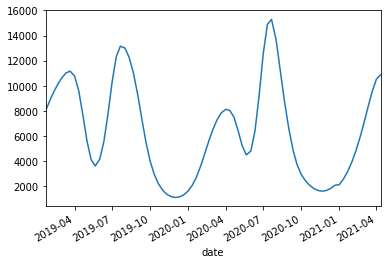

In [96]:
import pandas as pd
df = pd.read_csv("aggregated_fields.csv",index_col=["date","feature_index"],parse_dates=['date']).sort_index()

df.xs(0, level='feature_index', drop_level=True)["avg(band_0)"].plot()

In [93]:
df

,,avg(band_0)
date,feature_index,
2020-03-21 00:00:00+00:00,0,7836.002864
2020-04-01 00:00:00+00:00,0,8124.709486
2020-04-11 00:00:00+00:00,0,8042.187488
